In [1]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [2]:
dataname = "m4_monthly_dates"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_dates.


In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro']


In [4]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [5]:
train_entry

{'start': Timestamp('1976-06-30 00:00:00', freq='M'),
 'target': array([ 8000.,  8350.,  8570.,  7700.,  7080.,  6520.,  6070.,  6650.,
         6830.,  5710.,  5260.,  5470.,  7870.,  7360.,  8470.,  7880.,
         6750.,  6860.,  6220.,  6650.,  5450.,  5280.,  4970.,  5550.,
         7750.,  7760.,  7190.,  7440.,  6590.,  6210.,  6010.,  6390.,
         5780.,  5700.,  4680.,  4970.,  6850.,  6740.,  7490.,  6250.,
         6900.,  5870.,  5610.,  6310.,  6110.,  6090.,  5810.,  6060.,
         6950.,  7820.,  8270.,  7840.,  7850.,  6710.,  6220.,  7430.,
         6560.,  7080.,  6680.,  6900.,  8680.,  8450.,  8670.,  8470.,
         7910.,  8140.,  7310.,  7860.,  7730.,  7330.,  7430.,  7150.,
         8720.,  8340.,  8840.,  8780.,  8250.,  8180.,  7570.,  9280.,
         9220.,  9140.,  8950.,  8540.,  9360.,  9750.,  9270.,  8690.,
         8200.,  7610.,  7160.,  8280.,  7370.,  7130.,  6840.,  7260.,
         7430.,  7950.,  7790.,  8090.,  7480.,  6700.,  6650.,  6960.,


## Plot Series

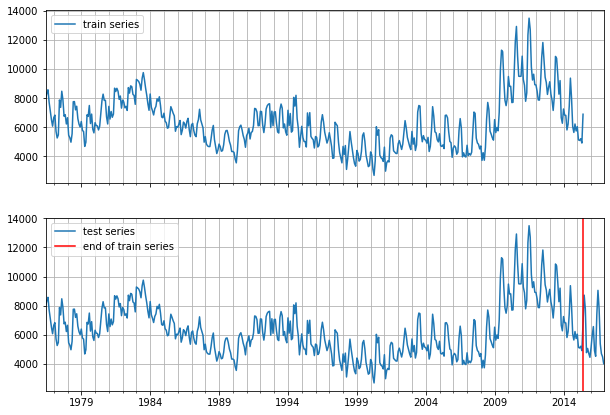

In [6]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [8]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_industry", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.93it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 9.155 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.316975
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.29it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[1] Elapsed time 9.729 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.926229
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.26it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 8.888 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.041195
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.56it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[3] Elapsed time 8.661 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[71] Elapsed time 8.623 seconds
INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=5.739314
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:08<00:00, 11.65it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[72] Elapsed time 8.591 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.925903
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[73] Elapsed time 8.724 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.990266
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[74] Elapsed time 8.727 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.908106
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:08<00:00, 11.78it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 8.494 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.6390

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.629026  0.160302  37.469821            0.136634            0.079668   

   seed  epochs  num_batches  
0    42     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.51it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 9.535 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.460546
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 11.03it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 9.075 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.950522
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.73it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 8.539 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.093229
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.80it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[3] Elapsed time 8.480 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.87it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[72] Elapsed time 10.142 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=7.419765
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[73] Elapsed time 10.815 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.259552
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.99it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[74] Elapsed time 9.106 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.681512
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.25it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[75] Elapsed time 9.759 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.141375
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.35it/s, avg_ep

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.153628  0.147192  14.873701            0.124566            0.074182   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.93it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 9.155 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.319013
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.29it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 8.863 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.857721
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.50it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 8.700 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.890883
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.67it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[3] Elapsed time 8.574 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

100%|██████████| 100/100 [00:14<00:00,  6.97it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[72] Elapsed time 14.355 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.641391
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.25it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[73] Elapsed time 16.006 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.968445
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:14<00:00,  7.04it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 14.218 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.769663
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:11<00:00,  8.66it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[75] Elapsed time 11.559 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.449951
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.11it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.185129  0.145603  20.921935             0.12404            0.083744   

   seed  epochs  num_batches  
0    44     100          100  
Wall time: 1h 21min 13s


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.629026,0.160302,37.469821,0.136634,0.079668,42,100,100
0,1.153628,0.147192,14.873701,0.124566,0.074182,43,100,100
0,1.185129,0.145603,20.921935,0.124040,0.083744,44,100,100


In [ ]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts10-own-m4_subsets.ipynb